# Airbnb Data Science Challenge (Shruti Jadon)

#### Goal: Given Feature of a Airbnb Booking, predict whether it will be booked or not.
When I read the problem statment without looking at features, I thought of this problem as time series analysis. But Upon reading about features and analyzing it further, it came to me that all features are independent of each other in terms of time. So I took this problem as classification problem.


Any data science problem have to go through 4 steps:

1. Preprocessing and Analysis of Data
2. Machine Learning Problem definition and model selection
3. Tuning of Model
4. Analysis of Model

Firstly, lets import all important libraries we will be using in this process.

## Answers to Questions:
#### 1. Build a model to predict whether a listing will receive a booking request for a calendar night.
To predict I used XGBoost and Neural Network as Final Models. Run run_me.sh file to get results and accuracies
you can also send a new .tsv file to test out predictions.

#### 2. Start with a baseline model that is more than a random guess and see how much you can improve from there.
As Baseline Model I used Logistic Regression, which was getting around 68% accuracy and imporved upon it using Cross Validation and by increaing capacity and quality of features. Finally I got around 83% accuracy with XGboost Model and around 80% with Neural Network.
						                    
#### 3. Show how you evaluate and improve your model performance. Explain your choice of evaluation technique.
Considering its binary classification, I used both Accuracy and F1 Score as Evaluation technique, as Sometimes dataset have bias, in this case I saw Bias for False Class. 

#### 4. Using the provided dataset, derive additional features to demonstrate your data sense and creativity.
Upon seeing different features, firstly I tried deriving features from ds and ds_night, just got weekday and month and put them sepeatelt. I also tried method PCA to reduce the number of dimensions to 40, it worked good with Logistic Regression but with Neural Network and XGBoost it didn't help much. But that is also True, considering Logistic Regression is one layered model, it can use some help for feature selection. But in case of XGBoost which is an ensemble with 1000 estimators, or Neural Networks with 500 epochs they pretty much do Dimensionality Reduction on their own.


#### 5. Identify how you would use your model and findings to improve Airbnb's marketplace by writing out specific recommendations.
This can be converted into a recommendation engine to run on daily basis, and show listing as options based on Longitude and Latitude Values. 

#### 6. What other prediction problems can be solved using this dataset? Suggest future work that could leverage this data.
By figuring out the important weights of features,we can suggest property listers to work of certain features so as to increase bookings.



In [325]:
# Import Libraries
import pandas as pd
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import heapq
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
import operator
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline  
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pickle as pkl
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2

#### 1. PreProcessing Step:
Pandas Library is mostly used for any form on analysis on data, because of the features of data frames. Its very convinient to fill nan values, or for plotting and analysis purpose.
upon importing the data in form of data frame, first thing is to check the data types of all features. It is necessary cause all machine learning models work through converting different types of features in a form of mathematical embeddings.

In [326]:
df=pd.read_table('saved_models/TH_data_challenge.tsv',sep='\t') #read the data
print df.dtypes #printing data types of data frames.

dim_is_requested                                         bool
ds_night                                               object
ds                                                     object
id_listing_anon                                        object
id_user_anon                                           object
m_effective_daily_price                               float64
m_pricing_cleaning_fee                                float64
dim_market                                             object
dim_lat                                               float64
dim_lng                                               float64
dim_room_type                                          object
dim_person_capacity                                     int64
dim_is_instant_bookable                                  bool
m_checkouts                                           float64
m_reviews                                             float64
days_since_last_booking                               float64
cancel_p

### Considering its a Classification Problem, the next thing to check if there is any form of bias in classes.
Upon plotting the graph, my observation was it was around 50% skewed, there are 2 things that can be done in this scenario:
1. make somewhat balanced class by removing other classes's values.
2. Subsample the less number of class to match up the level of first class.

##### But it is never recommended to do more than 50% subsampling, as that will mean more than 50% augmentation, a case of overfitting might occur, so I decided to go with option 1, randomly subsample False class to matchup the True Class entries.

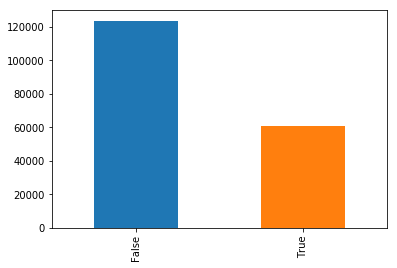

In [327]:
df['dim_is_requested'].value_counts().plot(kind='bar')
df1, df2 = [x for _, x in df.groupby(df['dim_is_requested']==False)]
df3=df2.sample(n=70000, random_state=1)
df=pd.concat([df1, df3])
Y=df.loc[:, :'dim_is_requested'] # Extracting Y_True Seperately

##### Upon Reading Features.xslx file which had description of Features, I decided to drop preprocess features of ds and ds_night to just include the month as I felt it might be important to know for which month maximum bookings happen.
Secondly, I dropped listing_id and user_id as I couldn't see any correlation between task and these features.
occ_occupancy_trailing_90_ds: seems to be highly positively correlated feature
days_since_last_booking : is highly -vely correlated feature.

In [328]:
df['ds']=pd.to_datetime(df['ds'])
df['ds_d'] = df['ds'].dt.day_name()
df['ds'] = pd.DatetimeIndex(df['ds']).month
df['ds_night'] = pd.DatetimeIndex(df['ds_night']).month
print df.corr()
df.drop(df.columns[[0,3,4]], axis=1, inplace=True)

                                                    dim_is_requested  \
dim_is_requested                                            1.000000   
ds_night                                                    0.068094   
ds                                                          0.004439   
m_effective_daily_price                                    -0.104763   
m_pricing_cleaning_fee                                      0.021027   
dim_lat                                                    -0.145408   
dim_lng                                                    -0.153848   
dim_person_capacity                                        -0.060619   
dim_is_instant_bookable                                     0.130146   
m_checkouts                                                 0.228129   
m_reviews                                                   0.221687   
days_since_last_booking                                    -0.235021   
cancel_policy                                               0.10

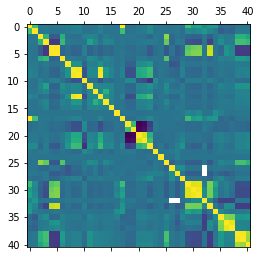

In [329]:
plt.matshow(df.corr()) #plot the correlation between all features to check if any feature is highly correlated

##### There are many times when values are missing, there are multiple ways to fill values, I have used the mean method for this case study.
Other Methods to fill values:
1. Train a Linear Regression/Classifier on that particular column with highly correlated column to it.
2. Fill 0 or -1 value, something that puts it as an outlier.
3. Fill it with mean.

In [330]:
def myfillna(series):
    if series.dtype is pd.np.dtype(float):
        return series.fillna(series.mean())
    elif series.dtype is pd.np.dtype(object):
        return series.fillna('.')
    else:
        return series

if(df.isnull().values.any()):
    df = df.apply(myfillna)

### Next step is to normalize certain columns that are needed to normalize

In [331]:
#normalize certain float columns
cols_to_norm = ['m_effective_daily_price','r_kdt_m_effective_daily_price_n100_p50','r_kdt_m_effective_daily_price_available_n100_p50','r_kdt_m_effective_daily_price_booked_n100_p50']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])

##### Convert Categorical/Boolean/Object Columns to their encodings

In [332]:
X_1=df.select_dtypes(include=[object,bool])
print X_1.head(3) # printing which have different type of object
X_2=df.select_dtypes(include=[float,int])

    dim_market    dim_room_type  dim_is_instant_bookable       ds_d
1  Los Angeles     Private room                     True     Monday
3  Los Angeles  Entire home/apt                    False   Saturday
4  Los Angeles  Entire home/apt                    False  Wednesday


In [333]:
def encoding(X):
    # encode labels with value between 0 and n_classes-1.
    le = preprocessing.LabelEncoder()
    # 2/3. FIT AND TRANSFORM
    X_2 = X.apply(le.fit_transform) # use df.apply() to apply le.fit_transform to all columns
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_2)
    onehotlabels = enc.transform(X_2).toarray()
    return onehotlabels

In [334]:
from sklearn.decomposition import PCA
X_=np.concatenate((encoding(X_1), X_2), axis=1)
le=preprocessing.LabelEncoder()
Y=le.fit_transform(Y)

dimension=False
if(dimension):
    pca = PCA(n_components=40)
    fit = pca.fit(X_)
    print("Explained Variance: %s") % fit.explained_variance_ratio_
    X_=pca.fit_transform(X_)
    
print X_.shape

(130510, 55)


## After Encoding and Preprocessing, I decided to go for a baseline model using Logistic Regression 
But for modelling purpose as well first we have to split our dataset in to train and test piece, considering its only around 18 lakh entries, so I decided to go for 70-30% split.

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X_, Y, test_size=0.30, random_state=42)

In [336]:
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
y_pred= clf.predict(X_test)
clf.predict_proba(X_test[:5]) 
print "Accuracy of Logistic Regression: "+str(accuracy_score(y_test, y_pred))
print "F1 Score of Logistic Regression: "+str(f1_score(y_test, y_pred, average=None))

Accuracy of Logistic Regression: 0.6918754629274896
F1 Score of Logistic Regression: [0.71791994 0.66053239]


#### As a Baseline Model, We can see we got around 68% accuracy.
Next step moving forward there are certain things to keep in mind:
1. Cross Validation: tune model to fit the purpose.
2. What Evaluation Metric to use? Accuracy is good, but for our case we can also look in to F1 score.

F1 Score is considered best metric when we have a case of biased class, for our scenario though we tried to balance our classes, we can still check our F1 Score values to see if they are performing well.

By looking at F1 Score Values of Logistic Regression, I can say, it is performing better for False class than with True Class, but that is cause of Data Bias, still overall it is close to Accuracy.

F1-score=2*precision*recall/(precision+recall)

F1 score reaches its best value at 1. For our scenario it is coming as close to Accuracy, which is good.

By looking at the score above, I thought there are 2 models to give a shot at:
1. Neural Network Approach
2. XGBoost: considering Ensembles always help.

## XG Boost Classifier
please run
-- pip install xgboost

I chose XGBoost as Boosting is based on weak learners (high bias, low variance). Boosting reduces error mainly by reducing bias (and to some extent variance, by aggregating the output from many models).

In [320]:
def cross_validate_XG(params,cv=5):
    param_untuned = {'max_depth':[5,7],'eta':[0.02,0.1,0.6]}
    estimator = xgb.XGBClassifier(**params)
    grid_search = GridSearchCV(estimator, param_grid=param_untuned, scoring='accuracy', cv=cv, verbose=1)
    grid_search.fit(X_train, y_train)
    df = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
    print df
    print 'the best_params : ', grid_search.best_params_
    print 'the best_score  : ', grid_search.best_score_
    evaluated=grid_search.best_params_
    params=dict(params.items() + evaluated.items())
    return params

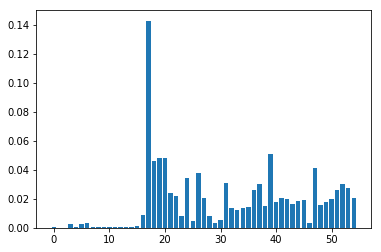

First two important features are: dim_has_wireless_internet, r_kdt_n_available_n100
Least two important features are: ds, m_effective_daily_price
Accuracy of xgboost : 0.8219548948994968
f1 score of xgboost : [0.82891152 0.81440856]


In [321]:
cross_validation=False # Please set this flag to True to tune parameters

params={'learning_rate':0.1, 'n_estimators':1000, 'min_child_weight':1, 'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8, 'objective': 'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'seed':27}

if(cross_validation):
    params=cross_validate_XG(params,3)  
    estimator = xgb.XGBClassifier(**params).fit(X_train,y_train)
    pkl.dump(estimator, open('saved_models/xgb_model_pca.pkl','wb'))
    feature_name=list(df.head())
    s=estimator.feature_importances_
    plt.bar(np.arange(len(s)),s)
    plt.show()
    indices=numpy.argsort(s)

print "First two important features are: "+ str(feature_name[indices[-1]])+", "+ str(str(feature_name[indices[-2]]))
print "Least two important features are: "+ str(feature_name[indices[0]])+", "+ str(str(feature_name[indices[1]]))

estimator= pkl.load(open('saved_models/xgb_model.pkl','rb'))
y_pred= estimator.predict(X_test)

print "Accuracy of xgboost : "+str(accuracy_score(y_test, y_pred))
print "f1 score of xgboost : "+ str(f1_score(y_test, y_pred, average=None))

### Ensemble XGboost seems to work pretty well, But for experimental purpose I also wanted to test how will Neural Network Perform. 
### Even F1 Score is coming very close to Accuracy, which is good news.

Neural network have certain parameters to consider while building:
1. Layers: I decided to go with 4 Layers at the end, I tested with less number, that was taking more time to converge, as the capacity was low.
2. Loss function: Its Binary Classification, so Binary Cross Entropy.
3. Optimizers: Though there are many other classes, I decided to go with Adam (Mini-batch) considering large enough dataset.
4. Metrics: I chose to go with accuracy as measure to check and save best model.

In [343]:
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle

def NeuralNetwork(n):
    model = Sequential()
    model.add(Dense(100, input_dim=n, kernel_initializer='normal', activation='relu'))
    model.add(Dense(70, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train():
    model=NeuralNetwork(X_train.shape[1])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    filepath="./saved_models/weights-NN.hdf5" # checkpoint
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=50, verbose=1, mode='auto')
    callbacks_list = [checkpoint,earlystop]
    # Fit the model
    history=model.fit(X_train, y_train, validation_split=0.20, epochs=1000, batch_size=128, callbacks=callbacks_list, verbose=0)
    return history

def visualize(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


Epoch 00001: val_acc improved from -inf to 0.69210, saving model to ./saved_models/weights-NN.hdf5

Epoch 00002: val_acc improved from 0.69210 to 0.69505, saving model to ./saved_models/weights-NN.hdf5

Epoch 00003: val_acc improved from 0.69505 to 0.70682, saving model to ./saved_models/weights-NN.hdf5

Epoch 00004: val_acc improved from 0.70682 to 0.71240, saving model to ./saved_models/weights-NN.hdf5

Epoch 00005: val_acc did not improve from 0.71240

Epoch 00006: val_acc improved from 0.71240 to 0.71886, saving model to ./saved_models/weights-NN.hdf5

Epoch 00007: val_acc did not improve from 0.71886

Epoch 00008: val_acc did not improve from 0.71886

Epoch 00009: val_acc did not improve from 0.71886

Epoch 00010: val_acc improved from 0.71886 to 0.71963, saving model to ./saved_models/weights-NN.hdf5

Epoch 00011: val_acc improved from 0.71963 to 0.72521, saving model to ./saved_models/weights-NN.hdf5

Epoch 00012: val_acc did not improve from 0.72521

Epoch 00013: val_acc did n


Epoch 00139: val_acc improved from 0.76067 to 0.76149, saving model to ./saved_models/weights-NN.hdf5

Epoch 00140: val_acc did not improve from 0.76149

Epoch 00141: val_acc did not improve from 0.76149

Epoch 00142: val_acc did not improve from 0.76149

Epoch 00143: val_acc did not improve from 0.76149

Epoch 00144: val_acc did not improve from 0.76149

Epoch 00145: val_acc did not improve from 0.76149

Epoch 00146: val_acc did not improve from 0.76149

Epoch 00147: val_acc did not improve from 0.76149

Epoch 00148: val_acc did not improve from 0.76149

Epoch 00149: val_acc improved from 0.76149 to 0.76237, saving model to ./saved_models/weights-NN.hdf5

Epoch 00150: val_acc did not improve from 0.76237

Epoch 00151: val_acc did not improve from 0.76237

Epoch 00152: val_acc did not improve from 0.76237

Epoch 00153: val_acc did not improve from 0.76237

Epoch 00154: val_acc did not improve from 0.76237

Epoch 00155: val_acc did not improve from 0.76237

Epoch 00156: val_acc did not

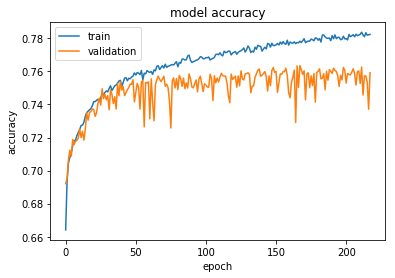

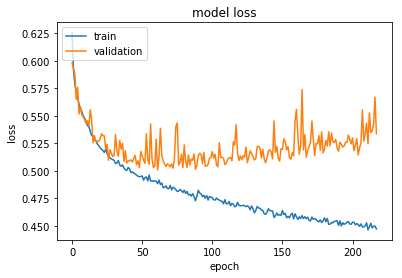

In [344]:
Train_NN=True # please set this flag=True if you wish to train
if(Train_NN):
    history=train()
    visualize(history)

In [345]:
model = NeuralNetwork(X_test.shape[1])
model.load_weights('./saved_models/weights-NN.hdf5')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
y_pred=model.predict_classes(X_test)
print accuracy_score(y_test, y_pred)
print f1_score(y_test, y_pred, average=None)

0.7677061783260541
[0.77586929 0.75892597]


#### Our Neural Network is performing good, but not as good as ensemble XGBoost, to improve this model:
1. Improve Features.
2. Increase Dataset: right now I chose less number of layers, as dataset amount wasn't high, and if we go beyond a certain number of epochs it will cause overfitting.
